In [1]:
import tensorflow as tf
tf.config.set_visible_devices(tf.config.list_physical_devices('CPU'))

from importlib import import_module
import keras
from keras.api._v2 import keras as KerasAPI
keras: KerasAPI = import_module("tensorflow.keras")
print(tf.__version__)

from keras import layers

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import plot_model

from sklearn.model_selection import train_test_split


2.10.0


### Preparing Data

In [2]:
random_state_value = 42
max_vocab_length = 10000
max_length = 25

In [3]:
df = pd.read_csv('data.csv')
df.columns

Index(['Category', 'Message', 'transformed_msg'], dtype='object')

In [4]:

# train_X, test_X, train_Y, test_Y = train_test_split(df['Message'], df['Category'], test_size=0.2, random_state=random_state_value)
train_X, test_X, train_Y, test_Y = train_test_split(df['transformed_msg'].astype(str), df['Category'], test_size=0.2, random_state=random_state_value)

### Words Length

In [5]:
x = map(lambda x: len(x.split(' ')), train_X)
x = np.array(list(x))
print(x.mean())
print(x.std())

8.693090909090909
6.269917656235842


### Vocabulary Size

In [6]:
# Split the text data into individual words
df_word_list = train_X.str.split()

# Create a set of unique words
unique_words = set([word for sublist in df_word_list for word in sublist])

# Count the number of unique words
unique_word_count = len(unique_words)

print("The dataframe contains", unique_word_count, "unique words.")

The dataframe contains 5935 unique words.


### Vocabulary

In [7]:
text_vectorizer = keras.layers.TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)
text_vectorizer.adapt(train_X)
text_vectorizer.get_vocabulary()[:10]

2023-04-26 02:28:31.814609: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


['', '[UNK]', 'u', 'call', 'go', '2', 'get', 'ur', 'come', 'gt']

In [8]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='loss',
                                                  patience=1,
                                                  min_delta=1e-4,
                                                  mode='min',
                                                  restore_best_weights=False, 
                                                  verbose=1)

checkpoint_callback = keras.callbacks.ModelCheckpoint('history/model',
                                                         save_weights_only=True, # save only the model weights
                                                         save_freq='epoch') # save the model weights which score the best validation accuracy) 

### Callbacks

In [9]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=4,
                                                  min_delta=1e-4,
                                                  mode='min',
                                                  restore_best_weights=True, 
                                                  verbose=1)

checkpoint_callback = keras.callbacks.ModelCheckpoint('history/model',
                                                         save_weights_only=True, # save only the model weights
                                                         save_freq="epoch") # save the model weights which score the best validation accuracy) 

### Model Arch I

In [10]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
model_1_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_1_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.LSTM(64)(x) 
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(2, activation="sigmoid")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = keras.Model(inputs, outputs, name="model_1")

In [11]:
# Compile GRU model
model_1.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 25)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 25, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________

In [12]:
# Fit model
model_3_history = model_1.fit(train_X,
                              train_Y,
                              epochs=10,
                              validation_data=(test_X, test_Y),
                              callbacks=[early_stopping_cb, checkpoint_callback])

Epoch 1/10
129/129 [==============================] - 3s 17ms/step - loss: 0.1857 - accuracy: 0.9362 - val_loss: 0.0528 - val_accuracy: 0.9855
Epoch 2/10
129/129 [==============================] - 2s 15ms/step - loss: 0.0354 - accuracy: 0.9918 - val_loss: 0.0416 - val_accuracy: 0.9893
Epoch 3/10
129/129 [==============================] - 2s 16ms/step - loss: 0.0127 - accuracy: 0.9968 - val_loss: 0.0682 - val_accuracy: 0.9845
Epoch 4/10
129/129 [==============================] - 2s 15ms/step - loss: 0.0144 - accuracy: 0.9961 - val_loss: 0.0748 - val_accuracy: 0.9845
Epoch 5/10
129/129 [==============================] - 2s 15ms/step - loss: 0.0048 - accuracy: 0.9993 - val_loss: 0.0671 - val_accuracy: 0.9855
Epoch 6/10
129/129 [==============================] - 2s 16ms/step - loss: 0.0041 - accuracy: 0.9995 - val_loss: 0.0735 - val_accuracy: 0.9864
Epoch 6: early stopping


In [13]:
model_1.evaluate(test_X, test_Y)

33/33 [==============================] - 0s 3ms/step - loss: 0.0416 - accuracy: 0.9893


[0.041569653898477554, 0.9893410801887512]

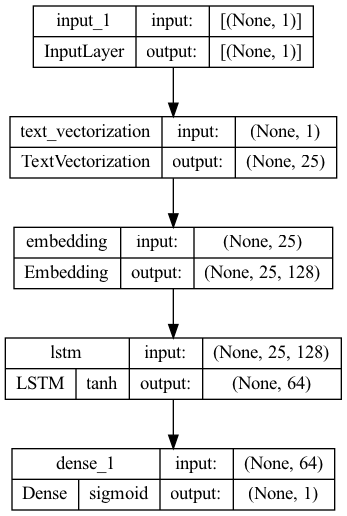

In [14]:
plot_model(model_1, show_shapes=True, show_layer_activations=True, expand_nested=True)